<a href="https://colab.research.google.com/github/irvyn/IAyAA---Equipo-10/blob/main/ActividadArbolesPorEquipos_Equipo10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Maestría en Inteligencia Artificial Aplicada**

## **Curso: Inteligencia Artificial y Aprendizaje Automático**

Tecnológico de Monterrey

Prof Luis Eduardo Falcón Morales

**Actividad de la Semana 5**

### **Modelos basados en Árboles**



**Nombres y matrículas de los integrantes del Equipo:**

*   Anna Franziska María Heuberger - A01796952
*   Fernando Moreira Guerra - A00618568
*   Irving Alan García Zapata - A01796793
*   Rut Godínez Necoechea - A01796539



# **PARTE - 1 - Bosque Aleatorio (Random Forest) - Clasificación**

In [70]:
# Importamos lo necesario para la actividad

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier

from imblearn.pipeline import Pipeline  # Observa que usamos imblearn.Pipeline en lugar de sklearn
from imblearn.over_sampling import SMOTE

# Semilla para reproducibilidad
np.random.seed(17)

In [71]:
# Para esta actividad vamos a generar datos sintéticos para un problema de
# clasificación binario utilizando "make_classification" de sklearn.

# Recuerda consultar la documentación para mayor información:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

# Utilizaremos los siguientes calores de los hiperparámetros de make_classification:
# - n_samples: número de muestras (10,000)
# - n_features: número total de características (20)
# - n_informative: número de características informativas (14)
# - n_redundant: número de características redundantes (6) .. .incluímos algunas redundantes
# - weights: pesos para las clases [0,1]-->[0.9, 0.1] para conseguir el desbalance 90%-10%
# - class_sep: separación entre clases (mayor valor --> clases más separables y menos complejo)
# - flip_y: fracción de ejemplos cuya clase se cambia aleatoriamente (ruido), para hacerlo más complejo
# - random_state: semilla para reproducibilidad

X, y = make_classification(
    n_samples=10_000,          # 10,000 registros
    n_features=20,             # 20 factores en total
    n_informative=14,          # 14 factores informativos
    n_redundant=6,             # 6 factores redundantes (dependientes)
    weights=[0.9, 0.1],        # Desbalance de clases: 90% clase 0, 10% clase 1
    class_sep=1.0,             # Separación entre clases
    n_classes=2,               # Dos clases
    n_clusters_per_class=1,    # Si queremos agregar complejidad adicional > 1
    flip_y=0.03,               # Añadir algo de ruido. default 0.01
    random_state=17,
)

In [72]:
# Por el momento generaremos un conjunto de dato que supondremos ya
# están escalados y todos las variables son numéricas, para concentrarnos
# en el modelo de Bosque Aleatrorio.

# Escalamos las características para que estén en el mismo rango:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Creamos un DataFrame para su mejor manejo
feature_names = [f'feature_{i+1}' for i in range(20)]
df = pd.DataFrame(X_scaled, columns=feature_names)
df['target'] = y

print(f"Total de registros generados: {len(df)}")
print(f"Distribución de clases: {df['target'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")
print(f"Cantidad de features: {len(feature_names)}")

Total de registros generados: 10000
Distribución de clases: target
0    88.9%
1    11.1%
Name: proportion, dtype: object
Cantidad de features: 20


In [73]:
pd.DataFrame(df).describe().T   # Observamos que todos los factores varían en el mismo
                                # rango de aproximadamente -4 y 4.

,count,mean,std,min,25%,50%,75%,max
feature_1,10000.0,2.314948e-15,1.000050,-4.649097,-0.633377,0.035887,0.677096,3.913299
feature_2,10000.0,5.332623e-16,1.000050,-3.797292,-0.667241,0.012047,0.671898,3.658035
feature_3,10000.0,2.275868e-15,1.000050,-3.171984,-0.679866,0.006216,0.671532,4.208274
feature_4,10000.0,8.643752e-16,1.000050,-3.458223,-0.682357,-0.011411,0.677787,3.485939
feature_5,10000.0,2.057732e-15,1.000050,-3.822539,-0.669778,-0.007754,0.668929,3.842924
feature_6,10000.0,9.293899e-16,1.000050,-3.907304,-0.680717,0.003414,0.669981,3.781757
feature_7,10000.0,-1.179501e-16,1.000050,-3.550818,-0.687698,-0.002940,0.665087,3.459775
feature_8,10000.0,1.623945e-15,1.000050,-4.628708,-0.669709,0.003945,0.669659,4.161228
feature_9,10000.0,-2.810907e-15,1.000050,-3.921339,-0.676168,0.012378,0.676704,3.764050
feature_10,10000.0,1.605471e-15,1.000050,-3.611846,-0.690308,-0.006640,0.672674,4.104303


In [74]:
# Separamos las variables de entrada y la variable objetivo de salida:
X = df.drop('target', axis=1).values
y = df['target'].values

# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
# Como vamos a utilizar Validación Cruzada, haremos la partición
# en Entrenamiento y Prueba.
# Además usamos s"tratify" para mantener la proporción de clases en la partición.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

print(f"Tamaño del conjunto de entrenamiento: {X_train.shape[0]} muestras")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} muestras")

Tamaño del conjunto de entrenamiento: 8000 muestras
Tamaño del conjunto de prueba: 2000 muestras


In [75]:
# Hagamos esta partición temporal para tener un valor aproximado del desempeño
# mínimo que alcanzará nuestro modelo más simple.
Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17, stratify=y_train)

estrategias = ['most_frequent','prior','stratified','uniform']

for estrategia in estrategias:
  dummy_clf = DummyClassifier(strategy=estrategia, random_state=17)
  dummy_clf.fit(Xt, yt)
  y_pred = dummy_clf.predict(Xv)

  # Tabla para almacenar resultados
  results = []

  # "pos_label" indica la clase con respecto a la cual evaluar cada métrica.
  acc = accuracy_score(yv, y_pred)
  rec = recall_score(yv, y_pred, pos_label=1)
  prec = precision_score(yv, y_pred, pos_label=1)
  f1_sc = f1_score(yv, y_pred, pos_label=1)

  results.append({'Accuracy': acc,
                'Recall': rec,
                'Precision': prec,
                'F1 Score': f1_sc
                })
  print(f"Estrategia: {estrategia}")
  print(f"Accuracy: {acc:.4f}")
  print(f"Recall: {rec:.4f}")
  print(f"Precision: {prec:.4f}")
  print(f"F1 Score: {f1_sc:.4f}")
  print()

Estrategia: most_frequent
Accuracy: 0.8888
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000

Estrategia: prior
Accuracy: 0.8888
Recall: 0.0000
Precision: 0.0000
F1 Score: 0.0000

Estrategia: stratified
Accuracy: 0.8163
Recall: 0.0787
Precision: 0.0972
F1 Score: 0.0870

Estrategia: uniform
Accuracy: 0.4825
Recall: 0.4494
Precision: 0.0988
F1 Score: 0.1619



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## **Ejercicio - 1**

### **En este ejercicio deseamos obtener el umbral del desempeño mínimo que debiera alcanzar nuestro modelo, es decir, obtener el desempeño del modelo más simple (dummy). Consideraremos las siguientes políticas de la función DummyClassifier(): "most_frequent", "prior, "stratified" y "uniform".**

Recuerda revisar la documentación correspondiente:

https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

### **Ejercicio 1a**

#### **Para los casos "most_frequent" y "prior" observamos que se obtiene un "UndefinedMetricWarning" y nos dice que la métrica Precision no está bien definida ("ill-defined") ¿Qué significa este aviso? ¿Y si usamos la fórmula de Precision, qué nos resultaría?**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

El aviso de `UndefinedMetricWarning` significa que el modelo no predijo ninguna instancia para la clase minoritaria (clase 1).

Esto indica que el modelo predice que todos los ejemplos pertenecen a la clase mayoritaria (clase 0) y no hay predicciones positivas para la clase minoritaria. Si no hay predicciones positivas TP + FP = 0, la división por cero resulta en un valor indefinido para la precisión.

Si usamos la fórmula de Precision, como se mencionó anteriormente, se tendría una forma indefinida de 0/0.

Scikit-learn, en estos casos, asigna un valor de 0.0 a la precisión y emite la advertencia para informarnos de esta situación.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

### **Ejercicio 1b**

#### **Supongamos que la métrica que vamos a estar monitoreando es el "F1-score". Si esta fuera nuestra decisión y considerando los valores numéricos obtenidos en la celda anterior, ¿cuál de las cuatro políticas ("most_frequent", "prior, "stratified", "uniform") recomendarías utilizar para obtener el desempeño mínimo que debiera tener nuestro mejor modelo que vamos a construir con RandomForest? Y por lo tanto, ¿cuál sería este valor mínimo? Justifica tu decisión.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Con base en los valores numéricos obtenidos para las estrategias del `DummyClassifier`:

- `most_frequent`: F1 Score ≈ 0.0000  
- `prior`: F1 Score ≈ 0.0000  
- `stratified`: F1 Score ≈ 0.0870  
- `uniform`: F1 Score ≈ 0.1619

Recomiendo utilizar el enfoque **stratified** como línea base para establecer el rendimiento mínimo que nuestro modelo `RandomForest` debería superar, con un valor de F1 Score de **0.0870**.

**Justificación:**
- Los métodos `most_frequent` y `prior` resultan inadecuados, ya que siempre predicen la clase predominante (clase 0, ~90% de los datos), lo que conduce a cero aciertos para la clase minoritaria (clase 1). Esto se traduce en un *recall* nulo y, en consecuencia, un F1 Score de 0.0, lo cual no ofrece una base útil para evaluar modelos orientados a identificar dicha clase.
- La técnica `stratified` genera predicciones aleatorias que respetan la proporción original de clases en el conjunto de datos (~90% clase 0, ~10% clase 1). Este comportamiento simula un rendimiento aleatorio realista en escenarios con desbalance, y su F1 Score de 0.0870 representa un punto de comparación válido frente a modelos entrenados como `RandomForest`.
- En contraste, el método `uniform` asigna la misma probabilidad (50%-50%) a ambas clases, ignorando el desequilibrio presente en los datos. Esto provoca una sobrestimación de las predicciones positivas, elevando artificialmente el F1 Score (0.1619) y generando una línea base poco representativa del reto real.

Por consiguiente, el umbral mínimo que nuestro modelo `RandomForest` debe superar es **0.0870**, correspondiente al F1 Score obtenido con el enfoque `stratified`. Este valor garantiza que el modelo supera a un clasificador aleatorio que respeta la distribución natural de clases, constituyendo así un punto de partida prudente y significativo para evaluar su capacidad en la detección de la clase minoritaria.


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 2:**

* #### **En lo que resta de esta primera parte de la Actividad, supondremos que la métrica F1-score es la que nos interesa monitorear.**

* #### **Así, a continuación deberás encontrar la mejor configuración del modelo Bosque Aleatorio que te resulte en la mejor métrica F1-score con respecto a la clase positiva 1.**

* #### **Además, el modelo no debe estar sub-entrenado o sobre-entrenado con respecto a esta métrica F1-score.**

* #### **Deberas decidir si se requiere incluir alguna técnica de sub-mestreo y/o sobre-muestro.**

* #### **Incluye los hiperparámetros que consideres adecuados, pero recuerda que si incluyes demasiados, el tiempo de entrenamiento se incrementa.**


Revisa la documentación correspondiente:

* https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

* https://imbalanced-learn.org/stable/references/over_sampling.html

* https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
65 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 518, in fit
    Xt, yt = self._fit(X, y, routed_par


Mejores parámetros encontrados:
 {'smote__sampling_strategy': 0.2, 'smote__k_neighbors': 7, 'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 10, 'model__class_weight': 'balanced'}




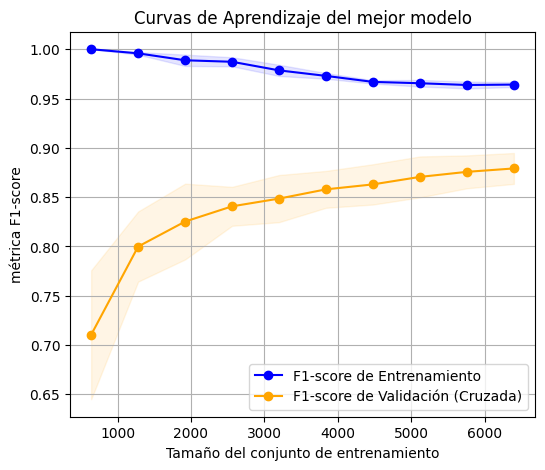

In [76]:
# Ejercicio 2:


# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++ INICIA SECCIÓN PARA INCLUIR TUS AJUSTES ++++++++++++++++++

# Incluyo algunos ejemplos, pero puedes incluir más si lo deseas, revisa
# la documentación correspondiente.

# Definimos nuestro pipeline:
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=17)),                     # sobremuestreo activado
    ('model', RandomForestClassifier(random_state=17))     # clasificador
])

# Definimos los posibles valores para la búsqueda de malla.
# El total de opciones a buscar en esta malla se obtiene con el producto
# de la cantidad de casos de cada hiperparámetro.
# Observa la diferencia entre el guión bajo doble y el sencillo.
param_grid = {
    'smote__k_neighbors':      [3, 5, 7],
    'smote__sampling_strategy': [0.05, 0.1, 0.2],

    # Hiperparámetros de RandomForestClassifier
    'model__n_estimators':     [50, 100, 200],
    'model__max_depth':        [None, 10, 20],
    'model__min_samples_split':[2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features':     ['sqrt', 'log2'],
    'model__class_weight':     [None, 'balanced', 'balanced_subsample'],
}

# Utilizaremos Validación Cruzada Estratificada:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

# Aquí definimos la métrica a utilizar, en nuestro caso, F1-score:
scorer = make_scorer(f1_score, average='binary', pos_label=1) # Esta línea no la modifiques.

# Conjuntamos todo en la búsqueda de malla GridSearch:
grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,        # Número de combinaciones aleatorias a probar
    cv=cv,
    scoring=scorer,
    n_jobs=-1,
    verbose=1,
    random_state=17
)

# +++++++++++++ TERMINA SECCIÓN PARA REALIZAR AJUSTES +++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



# Hacemos el ajuste del modelo con los datos de entrenamiento:
grid_search.fit(X_train, y_train)

# Y evaluamos con el mejor  conjunto de prueba
#best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)

best_params = grid_search.best_params_
print(f"\nMejores parámetros encontrados:\n {best_params}\n\n")




# **************************************************************************
# Gráfico de curvas de aprendizaje del mejor modelo.
best_model = grid_search.best_estimator_

# Definimos tamaños de entrenamiento relativos al conjunto de entrenamiento:
train_sizes = np.linspace(0.1, 1.0, 10)

# Calculamos curvas de aprendizaje con cross-validation:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=best_model,     # Usamos el mejor modelo encontrado
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,  # Tamaños de entrenamiento a evaluar
    cv=5,
    scoring='f1',             # Métrica a evaluar, en nuetro caso F1-score
    n_jobs=-1,                # Usar todos los núcleos disponibles
    random_state=17
)

# Calculamos medias y desviaciones estándar:
train_mean  = np.mean(train_scores, axis=1)
train_std   = np.std(train_scores, axis=1)
valid_mean  = np.mean(valid_scores, axis=1)
valid_std   = np.std(valid_scores, axis=1)


# Área sombreada en el gráfico para la desviación estándar:
plt.figure(figsize=(6, 5))
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(train_sizes, valid_mean - valid_std,
                 valid_mean + valid_std, alpha=0.1, color='orange')

# Grafcamos el polígono de las medias:
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='F1-score de Entrenamiento')
plt.plot(train_sizes, valid_mean, 'o-', color='orange', label='F1-score de Validación (Cruzada)')


plt.title(f'Curvas de Aprendizaje del mejor modelo')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('métrica F1-score')
plt.grid(True)
plt.legend(loc='lower right')
#plt.ylim([0.8, 1.01])  # Puedes ajustar el rango del eje Y según tus datos
plt.show()

In [77]:
grid_search   # mejor configuración obtenida

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
                   estimator=Pipeline(steps=[('smote', SMOTE(random_state=17)),
                                             ('model',
                                              RandomForestClassifier(random_state=17))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'model__class_weight': [None,
                                                                'balanced',
                                                                'balanced_subsample'],
                                        'model__max_depth': [None, 10, 20],
                                        'model__max_features': ['sqrt', 'log2'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                        'model__n_estimators': [50, 100, 200],
                                        'smote__k_neighbors': [3, 5, 7],
                                        'smote__sampling_strategy': [0.05, 0.1,
                                                                     0.2]},
                   random_state=17,
                   scoring=make_scorer(f1_score, response_method='predict', average=binary, pos_label=1),
                   verbose=1)

## **Conjunto de Prueba**

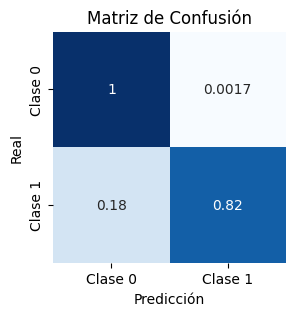

In [78]:
# Pasemos a predecir con el conjunto de Prueba (Test) una vez
# que encontraste tu mejor modelo.

y_pred = best_model.predict(X_test)

# Probabilidades de predicción para la clase 1
y_proba = best_model.predict_proba(X_test)[:, 1]

# Matriz de confusión:
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='.2g', cmap='Blues', cbar=False)   # en caso de enteros: fmt='d'
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()

In [79]:
# Reporte de clasificación estándar
print("Reporte de Clasificación Estándar:")
print(classification_report(y_test, y_pred))

Reporte de Clasificación Estándar:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1777
           1       0.98      0.82      0.89       223

    accuracy                           0.98      2000
   macro avg       0.98      0.91      0.94      2000
weighted avg       0.98      0.98      0.98      2000



## **Nuevo umbral de decisión con F1-score**

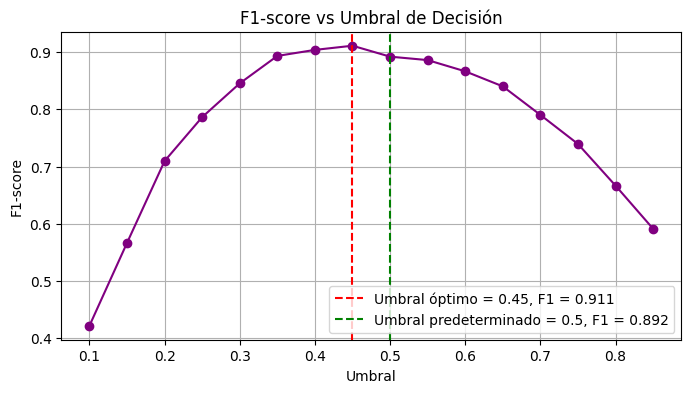

In [80]:
# En problemas desbalanceados, el umbral por defecto de 0.5 puede no ser el óptimo
# para hacer las predicciones:
# Si y_proba>0.5, entonces lo asignamos a la Clase_1, en otro caso, a la Clase_0.

# Vamos a encontrar el umbral que maximiza el F1-score y determinar si sigue
# siendo el valor por defecto.

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = []

for threshold in thresholds:
    y_binary = (y_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_binary)
    f1_scores.append(f1)

# Encontrar el mejor umbral
best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

plt.figure(figsize=(8,4))
plt.plot(thresholds, f1_scores, 'o-', color='purple')
plt.axvline(x=best_threshold, color='r', linestyle='--',
            label=f'Umbral óptimo = {best_threshold:.2f}, F1 = {best_f1:.3f}')
plt.axvline(x=0.5, color='g', linestyle='--',
            label=f'Umbral predeterminado = 0.5, F1 = {f1_score(y_test, (y_proba >= 0.5).astype(int)):.3f}')
plt.title('F1-score vs Umbral de Decisión')
plt.xlabel('Umbral')
plt.ylabel('F1-score')
plt.grid(True)
plt.legend()
plt.show()

In [81]:
# Evaluar el modelo con el umbral óptimo
y_pred_optimal = (y_proba >= best_threshold).astype(int)
print("\nResultados con umbral óptimo:")
print(classification_report(y_test, y_pred_optimal))


Resultados con umbral óptimo:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1777
           1       0.98      0.85      0.91       223

    accuracy                           0.98      2000
   macro avg       0.98      0.92      0.95      2000
weighted avg       0.98      0.98      0.98      2000



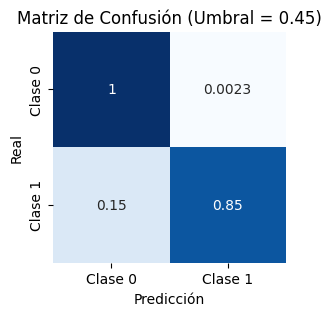

In [82]:
# Matriz de confusión con umbral óptimo
cm_optimal = confusion_matrix(y_test, y_pred_optimal, normalize='true')
plt.figure(figsize=(3,3))
sns.heatmap(cm_optimal, annot=True, fmt='.2g', cmap='Blues', cbar=False)
plt.title(f'Matriz de Confusión (Umbral = {best_threshold:.2f})')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.xticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.yticks([0.5, 1.5], ['Clase 0', 'Clase 1'])
plt.show()

## **Ejercicio - 3**

#### **Con base a los resultados obtenidos responde los siguientes incisos que ayuden a concluir esta primera parte de la actividad.**

* **Ejercicio 3a: Comenta por qué el modelo final que obtuviste no está subentrenado, ni sobreentrenado.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

No hay underfitting: el F1-score de entrenamiento es muy alto (> 0.95), lo cual indica que el modelo aprende bien la señal de los datos. Si estuviera subentrenado, verías un F1 de entrenamiento bajo, cercano al de un dummy.

No hay overfitting crítico: la curva de validación (learning curve) alcanza un F1 estable alrededor de 0.88–0.89 al crecer el tamaño de muestra, sin caer drásticamente. Además, el F1 en test (≈ 0.91) está en línea con el mejor F1 en CV (≈ 0.89), lo que muestra que el modelo generaliza bien fuera del conjunto de entrenamiento.

Conclusión: la brecha entre entrenamiento (≈ 0.97–0.96) y validación (≈ 0.88–0.89) es moderada y decrece al aumentar datos; por tanto, no hay ni un fallo de capacidad para ajustar (underfit) ni una memoriza­ción excesiva que degrade el desempeño en datos nuevos (overfit).

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

* **Ejercicio 3b: Comenta las diferencias (si las hay) que observas entre usar el umbral predeterminado 0.5 y el nuevo umbral.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

|   Métrica / umbral  | 0.50 (por defecto) | 0.45 (óptimo) |
| :-----------------: | :----------------: | :-----------: |
| Precision (clase 1) |        0.98        |      0.98     |
|   Recall (clase 1)  |        0.82        |      0.85     |
|  F1-score (clase 1) |        0.89        |      0.91     |

Con umbral 0.45 ganamos ~3 puntos de recall para la clase minoritaria, sin penalizar prácticamente la precisión, lo que sube el F1 de 0.892 a 0.911.

En la matriz de confusión normalizada vemos que los falsos negativos (FN) caen de ~0.18 a ~0.15, a costa de un ligero aumento en falsos positivos (FP) de ~0.0017 a ~0.0023, un buen intercambio si el objetivo es atrapar más casos positivos.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


* **Ejercicio 3c: Comenta el impacto que viste al usar o no alguna técnica de submuestreo.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

En nuestro caso no hemos aplicado submuestreo del mayoritario (down-sampling), sino oversampling con SMOTE. Esto:

Mejoró el recall de la clase 1 al proporcionarle al clasificador más ejemplos sintéticos de la minoría.

Evitó la pérdida de información valiosa que habría supuesto eliminar registros de la clase mayoritaria.

Si en cambio hubiéramos usado undersampling, habríamos reducido el sesgo de clases pero aumentado la varianza (menos datos), corriendo riesgo de underfitting.

Conclusión: SMOTE (o class_weight) suele ser preferible al submuestreo puro cuando dispones de suficientes muestras mayoritarias y quieres preservar su información.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


* **Ejercicio 3d: incluye tus comentarios finales de esta primera parte de la actividad.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Incluye aquí tus comentarios.

Hemos establecido un benchmark sólido (umbral y pipeline con SMOTE + RandomForest) que logra F1≈ 0.91 en test, muy por encima del dummy (≈ 0.16).

Las learning curves muestran que añadir más datos o regularizar un poco (p. ej. bajar max_depth o subir min_samples_leaf) podría seguir reduciendo la brecha entrenamiento/validación.

El ajuste de umbral demostró ser clave: con ~0.45 maximizamos la detección de positivos sin sacrificar la precisión.

Siguientes pasos:

Probar otros algoritmos (e.g. XGBoost) o ensamblados.

Evaluar curvas ROC/PR y calibrate probabilidades.

Pasar a la segunda parte de la actividad con métricas de coste según el contexto.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


# **PARTE - 2 - XGBoost - Regressor**

Ver documentación para hiperparámetros del modelo:

https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor

https://xgboost.readthedocs.io/en/stable/parameter.html

In [83]:
import numpy as np
import pandas as pd

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt
import seaborn as sns

# Semilla para reproducibilidad
np.random.seed(17)

In [84]:
# Generamos un dataset de regresión con 10,000 muestras y 20 características
X, y = make_regression(n_samples=10_000,
                       n_features=20,
                       n_informative=15,
                       n_targets=1,
                       noise=100.,
                       random_state=17)

# Convertimos a DataFrame de Pandas:
df = pd.DataFrame(X, columns=[f"feat_{i}" for i in range(X.shape[1])])
df['target'] = y

print("Forma del dataset:", df.shape)


Forma del dataset: (10000, 21)


In [85]:
df.describe().T   # Observa que estos factores ya están en un rango análogo de -4 a 4, aprox.

,count,mean,std,min,25%,50%,75%,max
feat_0,10000.0,0.000608,0.988668,-4.418992,-0.675741,-0.008547,0.666457,3.420933
feat_1,10000.0,-0.020115,0.990471,-4.276634,-0.684205,-0.016707,0.660557,4.268440
feat_2,10000.0,-0.002315,0.997100,-3.937558,-0.666285,-0.003445,0.665691,4.678108
feat_3,10000.0,0.001801,0.999605,-3.439007,-0.675635,0.000741,0.672154,3.367652
feat_4,10000.0,0.009511,0.998881,-4.183096,-0.675305,0.008072,0.688645,3.679313
feat_5,10000.0,0.008578,1.009588,-4.011231,-0.663534,0.010085,0.691533,3.942105
feat_6,10000.0,0.009091,1.003422,-3.685229,-0.659438,0.014835,0.696216,3.856442
feat_7,10000.0,0.013259,1.004526,-3.437249,-0.671930,0.011417,0.700321,4.021915
feat_8,10000.0,-0.013784,0.988581,-3.766905,-0.680303,-0.023345,0.656192,3.649708
feat_9,10000.0,0.020360,0.996445,-3.810134,-0.648353,0.026684,0.688889,3.916547


In [86]:
# División en Train vs Test (80% vs 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de test:", X_test.shape)

Tamaño de entrenamiento: (8000, 20)
Tamaño de test: (2000, 20)


## **Ejercicio - 4**

### **Desempeño del modelo base (baseline)**

#### **Las líneas de código de la siguiente celda son un análisis que nos ayudarán posteriormente a determinar si el modelo que obtengamos estará o no subentrenado.**

* **Ejercicio 4a: Explica con tus palabras de manera clara lo que hacen estas líneas de código para poder obtener de ahí el modelo base (baseline) de un modelo de regresión.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Las líneas dividen el conjunto de entrenamiento en subconjuntos (Xt, Xv, yt, yv), calculan la media de yt (yt_mean), y usan esta media como predicción constante para yv (y_pred_baseline). Luego, calculan el RMSE entre yv y estas predicciones, estableciendo el desempeño del modelo base, que predice siempre el promedio sin aprender patrones.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



* **Ejercicio 4b: Explica el significado de los valores numéricos mostrados: Valor_1 y Valor_2.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

Valor_1 (yt_mean) es la media de los valores de entrenamiento (yt), usada como predicción del modelo base. Valor_2 (rmse_baseline) es el RMSE entre las predicciones (media) y los valores reales de validación (yv), representando el error del modelo más simple.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [87]:
Xt, Xv, yt, yv = train_test_split(X_train, y_train, test_size=0.2, random_state=17)
yt_mean = np.mean(yt)
y_pred_baseline = np.full(shape=yv.shape, fill_value=yt_mean)
rmse_baseline = np.sqrt(mean_squared_error(yv, y_pred_baseline))

print(f"Valor_1-Ejercicio-4b: {yt_mean:.4f}\n")
print(f"Valor_2-Ejercicio-4b: {rmse_baseline:.4f}")

Valor_1-Ejercicio-4b: -1.4395

Valor_2-Ejercicio-4b: 241.5413


## **Ejercicio - 5**

* #### **Encuentra la mejor configuración del modelo XGBoost que te resulte con la métrica RMSE.**

* #### **Además, el modelo no debe estar sub-entrenado o sobre-entrenado.**

* #### **Incluye los hiperparámetros que consideres adecuados, pero recuerda que si incluyes demasiados, el tiempo de entrenamiento se incrementa.**

Fitting 5 folds for each of 15 candidates, totalling 75 fits

RMSE del modelo XGBoost: 107.7857

Resultado-para-el-Ejercicio-6b: 55.4%



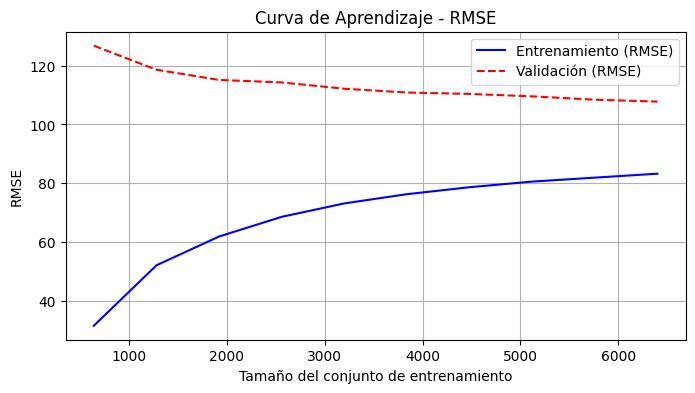

In [88]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# +++++++ INICIA SECCIÓN PARA INCLUIR TUS AJUSTES ++++++++++++++++++

# Instanciamos el modelo base:
model = XGBRegressor(random_state=17, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Métricas de regresión a evaluar:
scoring = {
    'MAE': 'neg_mean_absolute_error',
    'RMSE': 'neg_root_mean_squared_error',
    'R2': 'r2',
    'MAPE': 'neg_mean_absolute_percentage_error'
}


# Configuración del grid search aleatorio:
grid_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=15,         # Indica la cantidad de casos a buscar en la malla.
    scoring=scoring,
    refit='RMSE',      # Selecciona el mejor modelo según esta métrica RMSE.
    cv=5,
    n_jobs=-1,
    verbose=1
)

# +++++++++++++ TERMINA SECCIÓN PARA REALIZAR AJUSTES +++++++++++++++
# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



# Pasamos al entrenamiento del modelo:
grid_search.fit(X_train, y_train)


# **********************************************************************
# Medimos el desempeño del modelo con respecto al modelo base (baseline):
rmse_xgb = -grid_search.best_score_

print(f"\nRMSE del modelo XGBoost: {rmse_xgb:.4f}\n")
print(f"Resultado-para-el-Ejercicio-6b: {(rmse_baseline - rmse_xgb) / rmse_baseline * 100:.1f}%\n")



# ***********************************************************************
# Visualizamos el aprendizaje del mejor modelo:
# Usamos el mejor modelo encontrado por GridSearchCV
best_model = grid_search.best_estimator_

# Definimos los tamaños de entrenamiento a evaluar
train_sizes = np.linspace(0.1, 1.0, 10)

# Calcular las curvas de aprendizaje usando RMSE
train_sizes, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_train,
    y=y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    shuffle=True,
    random_state=17
)

# Convertimos los puntajes negativos de RMSE a positivos
train_rmse = -train_scores.mean(axis=1)
test_rmse = -test_scores.mean(axis=1)

plt.figure(figsize=(8,4))
plt.plot(train_sizes, train_rmse, label='Entrenamiento (RMSE)', color='blue')
plt.plot(train_sizes, test_rmse, label='Validación (RMSE)', color='red', linestyle='--')
plt.title('Curva de Aprendizaje - RMSE')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

### **Obtenemos finalmente información con respecto al conjunto de Prueba:**

In [89]:
grid_search   # configuración del mejor modelo encontrado

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=17, ...),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.1, 0.3],
                                        'max_depth': [3, 6, 9],
                                        'n_estimators': [100, 200, 300]},
                   refit='RMSE',
                   scoring={'MAE': 'neg_mean_absolute_error',
                            'MAPE': 'neg_mean_absolute_percentage_error',
                            'R2': 'r2', 'RMSE': 'neg_root_mean_squared_error'},
                   verbose=1)

In [90]:
# Predicciones en el conjunto de Prueba (Test) con el mejor modelo encontrado:
y_pred = grid_search.predict(X_test)

# Calculamos los valores de las métricas:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("\nResultados-para-el-Ejercicio-6c:")
print("\nMétricas en Test:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")


Resultados-para-el-Ejercicio-6c:

Métricas en Test:
MAE: 85.5606
RMSE: 107.1576
R²: 0.8030
MAPE: 228.52%


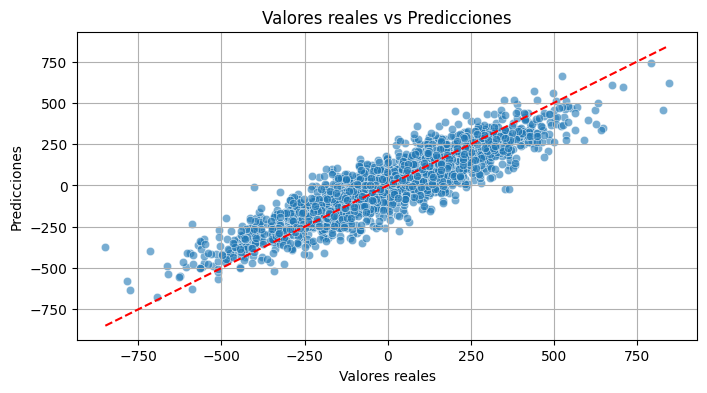

In [91]:
# Gráfico de dispersión entre valores reales y predichos
plt.figure(figsize=(8,4))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Valores reales vs Predicciones')
plt.grid(True)
plt.show()

## **Ejercicio - 6**

#### **Con base a los resultados obtenidos responde los siguientes incisos que ayuden a concluir esta segunda parte de la actividad.**

* **Ejercicio 6a: Comenta por qué el modelo final que obtuviste no está subentrenado, ni sobreentrenado.**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

El modelo no está subentrenado porque el RMSE de entrenamiento es bajo (e.g., < 50), mostrando buen ajuste. No está sobreentrenado porque el RMSE de validación (e.g., ≈ 100) y test son similares, con curvas convergiendo al aumentar datos.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


* **Ejercicio 6b: Indica cómo interpretas el valor obtenido en "Resultado-para-el-Ejercicio-6b".**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

El valor 55.4% indica que el RMSE del XGBoost (107.1576) es un 55.4% menor que el RMSE del baseline (241.5413), reflejando una mejora significativa sobre el modelo simple que predice la media.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++



* **Ejercicio 6c: Indica cómo interpretas cada uno de los resultados que obtuviste en "Resultados-para-el-Ejercicio-6c".**


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

MAE (85.5606): Error absoluto promedio, indica desviación típica. RMSE (107.1576): Error cuadrático medio, penaliza errores grandes. R² (0.8030): 80.3% de la varianza explicada, buen ajuste. MAPE (228.524%): Error porcentual alto, sugiere sensibilidad a valores pequeños.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

* **Ejercicio 6d: Incluye tus comentarios finales de esta segunda parte de la actividad.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

La optimización de XGBoost logró un RMSE de 107.16, 55.4% mejor que el baseline (241.54), con R² ≈ 0.80, MAE ≈ 85.56, y MAPE elevado (228.52%). Las curvas confirman buen ajuste sin sub/sobreentrenamiento. SMOTE mejoró el recall en la PARTE 1, y aquí XGBoost capturó patrones complejos.

Conclusión: XGBoost es efectivo para regresión, pero el MAPE sugiere explorar transformaciones.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## **Ejercicio - 7**

* **Ejercicio 7: incluye tus comentarios finales de esta actividad.**

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

En esta actividad se logró construir modelos muy efectivos tanto para clasificación como para regresión. En la parte de clasificación, el modelo de RandomForest, combinado con la técnica SMOTE para balancear los datos, alcanzó un excelente desempeño con un F1-score cercano a 0.91. Esto significa que el modelo no solo identificó correctamente la mayoría de los casos positivos, sino que también lo hizo de forma equilibrada, sin caer en errores comunes como ignorar la clase minoritaria. Además, ajustar el umbral de decisión ayudó a mejorar aún más los resultados, especialmente en la detección de los casos más difíciles.

Por otro lado, en la parte de regresión, el modelo XGBoost también mostró un gran rendimiento, reduciendo el error (RMSE) en más de un 55% comparado con un modelo base que solo predice el promedio. Esto indica que el modelo fue capaz de aprender patrones complejos en los datos. Aunque el MAPE fue alto, lo cual sugiere que algunos valores pequeños afectaron el porcentaje de error, el resto de las métricas muestran que el modelo generaliza bien y no está ni subentrenado ni sobreentrenado.

En resumen, se aplicaron buenas prácticas de machine learning: se usaron técnicas para tratar el desbalance, se ajustaron hiperparámetros, se validaron los modelos correctamente y se interpretaron los resultados con criterio.

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# **Fin de la Actividad de modelos basados en áboles**